# AST 4930 Week 6

## Permutation importance

### Let's load and split the Iris dataset.

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Let's find the best SVM model.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Remember that we need feature scaling for SVM.
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC(kernel='rbf'))
])

# Choose hyperparameters to optimize.
param_grid = {'SVM__C': [0.01, 0.1, 1., 10., 100.],
              'SVM__gamma': [0.01, 0.1, 1., 10., 100.]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'SVM__C': 1.0, 'SVM__gamma': 0.1}
Best model: Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(gamma=0.1))])
Test score: 0.97


### We can also optimize SVM kernels using GridSearchCV, with the expense of potential redundant searches.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Remember that we need feature scaling for SVM.
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC())
])

# Choose hyperparameters to optimize.
param_grid = {'SVM__kernel':['poly', 'rbf'],
              'SVM__C': [0.01, 0.1, 1., 10., 100.],
              'SVM__gamma': [0.01, 0.1, 1., 10., 100.],
              'SVM__degree': [1, 2, 4, 8]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'SVM__C': 0.01, 'SVM__degree': 1, 'SVM__gamma': 100.0, 'SVM__kernel': 'poly'}
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=0.01, degree=1, gamma=100.0, kernel='poly'))])
Test score: 0.97


In [4]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 

### Let's compute the permutation importance.

In [6]:
# We first fit our best model.

model = grid_search.best_estimator_
model.fit(X_train, y_train)

# We then compute the permutation importance using the test data.
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

### Let's print out what's in the output.

In [7]:
r

{'importances_mean': array([0.03157895, 0.01842105, 0.27631579, 0.29210526]),
 'importances_std': array([0.03068922, 0.02644704, 0.05027625, 0.05190285]),
 'importances': array([[ 0.02631579,  0.05263158,  0.10526316,  0.        ,  0.02631579,
          0.02631579,  0.        ,  0.        ,  0.05263158,  0.02631579],
        [ 0.05263158,  0.02631579,  0.        ,  0.        ,  0.05263158,
          0.        ,  0.02631579,  0.05263158, -0.02631579,  0.        ],
        [ 0.31578947,  0.39473684,  0.28947368,  0.23684211,  0.26315789,
          0.23684211,  0.28947368,  0.28947368,  0.23684211,  0.21052632],
        [ 0.36842105,  0.34210526,  0.23684211,  0.28947368,  0.26315789,
          0.28947368,  0.23684211,  0.34210526,  0.21052632,  0.34210526]])}

### Let's make a feature importance plot.

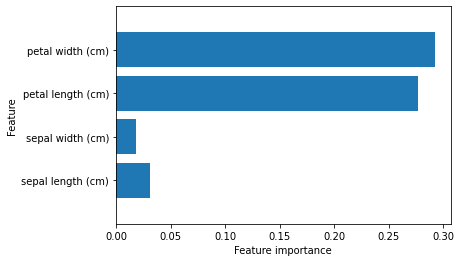

In [8]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), iris.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(r)

### We can also make a box plot.

Text(0, 0.5, 'Feature')

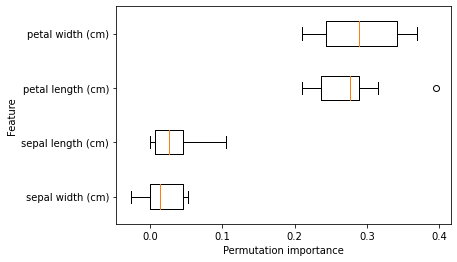

In [9]:
sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=np.array(iris.feature_names)[sorted_idx])

ax.set_xlabel("Permutation importance")
ax.set_ylabel("Feature")


### Permutation importance with correlated features

#### The following example from sklearn uses Random Forest, which we haven learned yet. So don't worry about what it does for now.

In [10]:
# From https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
# To learn more about the breast cancer dataset: https://scikit-learn.org/stable/datasets/toy_dataset.html

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(model.score(X_test, y_test)))

Accuracy on test data: 0.97


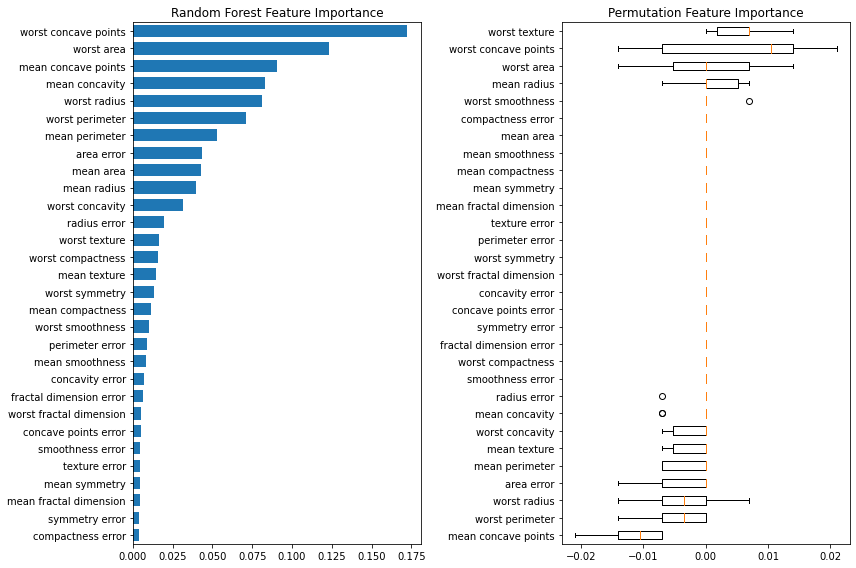

In [11]:
# This is the impurity-based feature importance from Random Forest

tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,
         model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model.feature_importances_)))
ax1.set_title('Random Forest Feature Importance')

# This is the permutation feature importance

r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = r.importances_mean.argsort()

ax2.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax2.set_title('Permutation Feature Importance')

fig.tight_layout()
plt.show()

### TODO: Using the breast cancer data, find the best SVM model and compute the permutation feature importance. How does that compare with Random Forest feature importance?

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Remember that we need feature scaling for SVM.
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC(kernel='rbf'))
])

# Choose hyperparameters to optimize.
param_grid = {'SVM__C': [0.1, 1., 10., 100., 1.0e4, 1.0e5],
              'SVM__gamma': [1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 0.01, 0.1]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'SVM__C': 10000.0, 'SVM__gamma': 1e-05}
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=10000.0, gamma=1e-05))])
Test score: 0.97


### TODO: make a heatmap

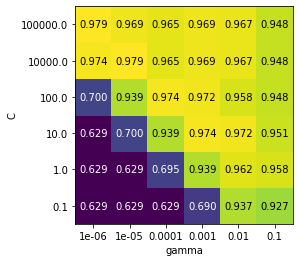

In [13]:
import pandas as pd
import mglearn
import numpy as np

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['SVM__C']),len(param_grid['SVM__gamma']))

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['SVM__gamma'],
                     ylabel='C', yticklabels=param_grid['SVM__C'], cmap='viridis', fmt="%.3f")


### TODO: make a confusion matrix

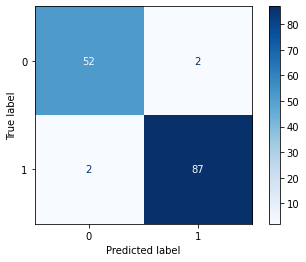

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# make a confusion matrix

cm = confusion_matrix(grid_search.predict(X_test), y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

### TODO: Compute the permutation importance.

In [15]:
from sklearn.inspection import permutation_importance

model = grid_search.best_estimator_
model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0, n_jobs=2)

### TODO: Make a plot showing permutation importance.

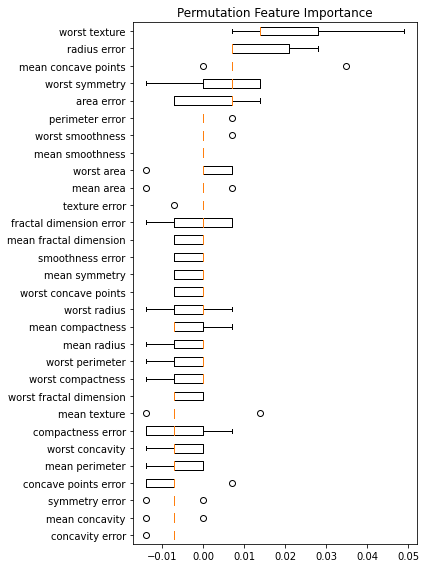

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 8))

perm_sorted_idx = r.importances_mean.argsort()

ax.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax.set_title('Permutation Feature Importance')

fig.tight_layout()
plt.show()
